In [1]:
# Google Drive 연동
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from IPython import display

import os
from tqdm import tqdm
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [59]:
# Load Pocketmon Dataset
def find_path(path):
    file_list = os.listdir(path)
    return file_list

def png_to_np(path, file_list, read_type='rgb'):
    pix = []
    for idx in tqdm(range(len(file_list))):
      file_name = file_list[idx]
      if read_type == "rgb":
        image = PIL.Image.open(path + '/' + file_name) # (256, 256, 3)
      elif read_type == "gray":
        image = PIL.Image.open(path + '/' + file_name).convert("L") # (256, 256, 1)
      np_image = np.array(image).astype(np.float32) / 255.0
      pix.append(np_image)
    return pix

In [106]:
# 포켓몬 데이터셋 받는부분
image_size = 128
channel = 1
read_type = lambda channel: 'rgb' if channel==3 else 'gray'
batch_size = 64
train_size = 10 #768 #616 
test_size =  2  #130 #154 

path = 'drive/MyDrive/dataset/Dobby/Dobby_{}'.format(str(image_size))  # 'drive/MyDrive/dataset/Human/Human_{}'  # 'drive/MyDrive/dataset/pockemon/jpg/jpg_dataset_{}'

file_list = find_path(path)
images = png_to_np(path, file_list, read_type=read_type(channel))

train_dataset = np.array(images[:train_size])
test_dataset = np.array(images[train_size:])

# GrayScale일때 1channel을 만들어주기위해 활용
if channel == 1:
  train_dataset = train_dataset[..., tf.newaxis]
  test_dataset = test_dataset[..., tf.newaxis]

print(train_dataset.shape, test_dataset.shape)

#train_dataset = (tf.data.Dataset.from_tensor_slices(train_dataset)
#                 .shuffle(train_size).batch(batch_size))
#test_dataset = (tf.data.Dataset.from_tensor_slices(test_dataset)
#                .shuffle(test_size).batch(batch_size))

100%|██████████| 12/12 [00:08<00:00,  1.50it/s]

(10, 128, 128, 1) (2, 128, 128, 1)


In [ ]:
# MNIST 데이터셋 받는부분
mnist = tf.keras.datasets.mnist

# (훈련 이미지, 훈련 레이블), (시험 이미지, 시험 레이블)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_dataset = x_train[..., tf.newaxis]
test_dataset = x_test[..., tf.newaxis]

#train_dataset = train_dataset.reshape(60000, 784)
#test_dataset = test_dataset.reshape(10000, 784)

# Normal Auto Encoder Architecture

In [107]:
leakyrelu = tf.keras.layers.LeakyReLU()
conv2d = tf.keras.layers.Conv2D
conv2d_t = tf.keras.layers.Conv2DTranspose
flatten = tf.keras.layers.Flatten
dense = tf.keras.layers.Dense
reshape = tf.keras.layers.Reshape

input_img = tf.keras.Input(shape=(image_size, image_size, 1))

# encoder
encoder1 = conv2d(32, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(input_img)   # 128 -> 64 
encoder2 = conv2d(64, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(encoder1)    # 64 -> 32
#encoder3 = conv2d(128, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(encoder2)   # 32 -> 16  
#encoder4 = conv2d(256, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(encoder3)   # 16 -> 8

#flatten = flatten()(encoder2)
#dense1 = dense(10, activation=leakyrelu)(flatten)
#dense2 = dense(int(image_size/4) * int(image_size/4) * 64, activation=leakyrelu)(dense1)
#dense3 = dense(8 * 8 * 256, activation='sigmoid')(dense2)
#dense4 = dense(8 * 8 * 256, activation='sigmoid')(dense3)

#reshape = reshape(target_shape=(int(image_size/4), int(image_size/4), 64), input_shape=(dense2,))(dense2)
# decoder
#decoder1 = conv2d_t(128, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(encoder4) 
#decoder2 = conv2d_t(64, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(decoder1) 
decoder3 = conv2d_t(32, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(encoder2)
decoder4 = conv2d_t(1, kernel_size=(2, 2), strides=2, padding="same")(decoder3)

autoencoder = tf.keras.Model(inputs=input_img, outputs=decoder4)

In [108]:
autoencoder.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 64, 64, 32)        160       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 64)        8256      
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 64, 64, 32)        8224      
_________________________________________________________________
conv2d_transpose_22 (Conv2DT (None, 128, 128, 1)       129       
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________


In [112]:
autoencoder.compile(optimizer='adam', loss='MSE')
autoencoder.fit(train_dataset, train_dataset,
                epochs=50,
                batch_size=64,
                shuffle=True,
                validation_data=(test_dataset, test_dataset))

Epoch 1/50
1/1 [==============================] - 0s 453ms/step - loss: 0.0056 - val_loss: 0.0059
Epoch 2/50
1/1 [==============================] - 0s 21ms/step - loss: 0.0053 - val_loss: 0.0058
Epoch 3/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0051 - val_loss: 0.0054
Epoch 4/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0047 - val_loss: 0.0053
Epoch 5/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0044 - val_loss: 0.0053
Epoch 6/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0044 - val_loss: 0.0052
Epoch 7/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0043 - val_loss: 0.0049
Epoch 8/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0040 - val_loss: 0.0048
Epoch 9/50
1/1 [==============================] - 0s 20ms/step - loss: 0.0039 - val_loss: 0.0048
Epoch 10/50
1/1 [==============================] - 0s 21ms/step - loss: 0.0039 - val_loss: 0.0048
Epoch 11/50
1/1 [===========

In [113]:
reconstructed_imgs = autoencoder.predict(test_dataset)
if channel == 3:
  reconstructed_imgs = (np.array(reconstructed_imgs) * 255).astype(np.int64)

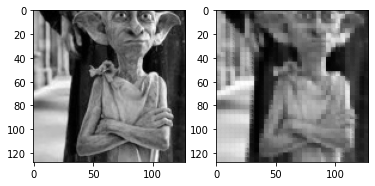

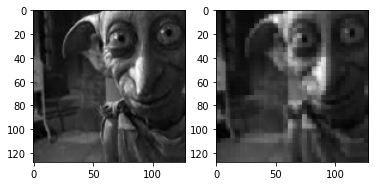

In [114]:
rgb_size = (image_size, image_size, 3)
gray_size = (image_size, image_size)
epochs = 2  # how many digits we will display
for i in range(epochs):
    plt.subplot(121)
    # display original
    if channel == 1:
      plt.imshow(test_dataset[i].reshape(gray_size), cmap='gray')
    else:
      plt.imshow(test_dataset[i].reshape(rgb_size))

    # display reconstructed image
    plt.subplot(122)
    if channel == 1:
      plt.imshow(reconstructed_imgs[i].reshape(gray_size), cmap='gray')
    else:
      plt.imshow(reconstructed_imgs[i].reshape(rgb_size))
    plt.show()